# Flexible Architecure with Optuna Optimization

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import optuna

import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

cuda


# Dataset & DataLoaders

In [ ]:
def get_dataloaders(batch_size):

    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4471), (0.2023, 0.1994, 0.2010))
        
    ])

    val_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4471), (0.2023, 0.1994, 0.2010))
        
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=train_transform
    )
    
    val_dataset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=val_transform
    )

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )

    return train_loader, val_loader


# Model

In [ ]:
class FlexibleCNN(nn.Module):
    def __init__(self, n_layers, n_filters, kernel_sizes, dropout_rate, fc_size):
        super(FlexibleCNN, self).__init__()

        blocks = []

        in_channels = 3

        for i in range(n_layers):

            out_channels = n_filters[i]
            kernel_size = kernel_sizes[i]

            padding = (kernel_size - 1) // 2

            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )

            blocks.append(block)

            in_channels = out_channels
        
        self.features = nn.Sequential(*blocks)

        self.dropout_rate = dropout_rate
        self.fc_size = fc_size

        self.classifier = None
    
    def _create_classifier(self, flattened_size, device):
        self.classifier = nn.Sequential(
            nn.Dropout(self.dropout_rate),
            nn.Linear(flattened_size, self.fc_size),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout_rate),
            nn.Linear(self.fc_size, 10)
        ).to(device)
    
    def forward(self, x):
        device = x.device

        x = self.features(x)

        flattened = torch.flatten(x, 1)
        flattened_size = flattened.size(1)

        if self.classifier is None:
            self._create_classifier(flattened_size, device)
        
        return self.classifier(flattened)

# Utility Functions

In [6]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()

    correct = 0
    total = 0

    loss_per_epoch = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_per_epoch += loss.item()

        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    loss_per_epoch /= len(train_loader)
    accuracy = correct / total
    return loss_per_epoch, accuracy

In [7]:
def validate(model, val_loader, criterion, device):
    model.eval()

    correct = 0
    total = 0

    loss_per_epoch = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss_per_epoch += loss.item()

            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    loss_per_epoch /= len(val_loader)
    
    return loss_per_epoch, accuracy


In [8]:
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):

    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot loss curves
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy curves
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Optuna Objective Function

In [ ]:
def objective(trial, device):

    # Model Hyperparameters
    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_filters = [trial.suggest_int(f"n_filters_{i}", 16, 128) for i in range(n_layers)]
    kernel_sizes = [trial.suggest_categorical(f"kernel_size_{i}", [3, 5]) for i in range(n_layers)]

    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    fc_size = trial.suggest_int("fc_size", 64, 256)

    # Training Hyperparameter
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    epochs = 10

    train_loader, val_loader = get_dataloaders(batch_size)

    model = FlexibleCNN(n_layers, n_filters, kernel_sizes, dropout_rate, fc_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        trial.report(val_acc, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        best_val_acc = max(best_val_acc, val_acc)
    
    return best_val_acc

# Run Optuna Study

In [10]:
study = optuna.create_study(
    direction = "maximize",
    sampler = optuna.samplers.TPESampler(),
    pruner = optuna.pruners.MedianPruner()
)

study.optimize(lambda trial: objective(trial, device), n_trials=10)

best_trial = study.best_trial
print("Best Trial: ", best_trial.params)

[I 2025-12-04 19:30:42,129] A new study created in memory with name: no-name-b620e351-4abe-418e-be98-54db40ca7d9b
100%|██████████| 170M/170M [00:03<00:00, 42.9MB/s] 
[I 2025-12-04 19:34:28,368] Trial 0 finished with value: 0.2273 and parameters: {'n_layers': 2, 'n_filters_0': 124, 'n_filters_1': 18, 'kernel_size_0': 3, 'kernel_size_1': 5, 'dropout_rate': 0.25941632864510217, 'fc_size': 79, 'batch_size': 64, 'lr': 0.005392018135324637}. Best is trial 0 with value: 0.2273.
[I 2025-12-04 19:38:25,376] Trial 1 finished with value: 0.2701 and parameters: {'n_layers': 1, 'n_filters_0': 64, 'kernel_size_0': 5, 'dropout_rate': 0.2894990170817514, 'fc_size': 208, 'batch_size': 32, 'lr': 0.0003059944866846917}. Best is trial 1 with value: 0.2701.
[I 2025-12-04 19:41:45,252] Trial 2 finished with value: 0.3277 and parameters: {'n_layers': 1, 'n_filters_0': 123, 'kernel_size_0': 5, 'dropout_rate': 0.39214008479364304, 'fc_size': 146, 'batch_size': 128, 'lr': 0.0019563688331649316}. Best is trial 2

Best Trial:  {'n_layers': 2, 'n_filters_0': 102, 'n_filters_1': 95, 'kernel_size_0': 5, 'kernel_size_1': 3, 'dropout_rate': 0.2158787991486799, 'fc_size': 118, 'batch_size': 32, 'lr': 0.0031449138108785085}


# Train Model On Best Hyperparameters

In [11]:
train_loader, val_loader = get_dataloaders(best_trial.params["batch_size"])
final_model = FlexibleCNN(
    best_trial.params["n_layers"],
    [best_trial.params[f"n_filters_{i}"] for i in range(best_trial.params["n_layers"])],
    [best_trial.params[f"kernel_size_{i}"] for i in range(best_trial.params["n_layers"])],
    best_trial.params["dropout_rate"],
    best_trial.params["fc_size"]
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_trial.params["lr"])

EPOCHS = 15

train_history = {"train_loss": [], "train_acc": []}
val_history = {"val_loss": [], "val_acc": []}

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(final_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(final_model, val_loader, criterion, device)

    train_history["train_loss"].append(train_loss)
    train_history["train_acc"].append(train_acc)
    
    val_history["val_loss"].append(val_loss)
    val_history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("\nTraining Complete!")


Epoch 1/15 - Train Loss: 2.0867, Train Acc: 0.2370, Val Loss: 1.8613, Val Acc: 0.3418
Epoch 2/15 - Train Loss: 1.9761, Train Acc: 0.2859, Val Loss: 1.8140, Val Acc: 0.3638
Epoch 3/15 - Train Loss: 1.9269, Train Acc: 0.3067, Val Loss: 1.7612, Val Acc: 0.3816
Epoch 4/15 - Train Loss: 1.8942, Train Acc: 0.3200, Val Loss: 1.6994, Val Acc: 0.4054
Epoch 5/15 - Train Loss: 1.8598, Train Acc: 0.3340, Val Loss: 1.7173, Val Acc: 0.4069
Epoch 6/15 - Train Loss: 1.8458, Train Acc: 0.3387, Val Loss: 1.6465, Val Acc: 0.4214
Epoch 7/15 - Train Loss: 1.8228, Train Acc: 0.3497, Val Loss: 1.6367, Val Acc: 0.4238
Epoch 8/15 - Train Loss: 1.8102, Train Acc: 0.3532, Val Loss: 1.6257, Val Acc: 0.4363
Epoch 9/15 - Train Loss: 1.8024, Train Acc: 0.3545, Val Loss: 1.6097, Val Acc: 0.4399
Epoch 10/15 - Train Loss: 1.7887, Train Acc: 0.3593, Val Loss: 1.6346, Val Acc: 0.4228
Epoch 11/15 - Train Loss: 1.7783, Train Acc: 0.3638, Val Loss: 1.6095, Val Acc: 0.4356
Epoch 12/15 - Train Loss: 1.7762, Train Acc: 0.3639,

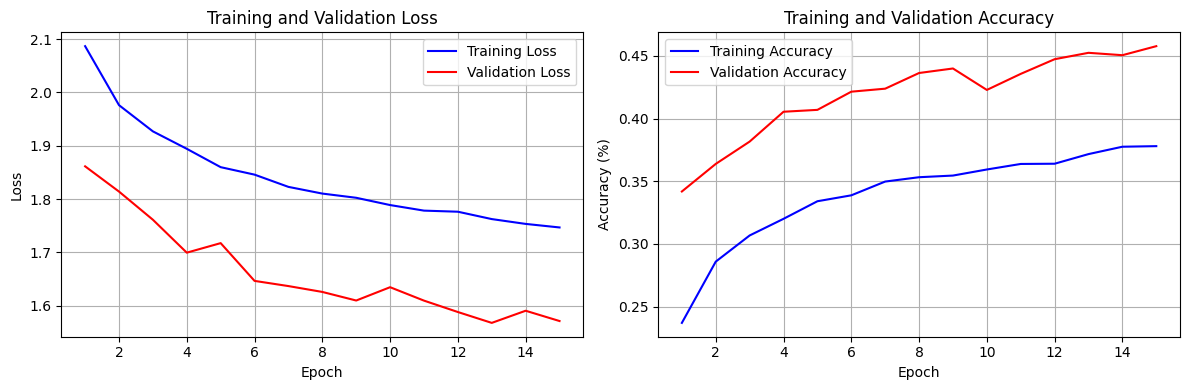

In [12]:
plot_learning_curves(train_history["train_loss"], val_history["val_loss"], train_history["train_acc"], val_history["val_acc"])